In [5]:
# 列出所有数据文件地址
file_name_list = ["subject_dystonia_hcc_area_lh.dat",
                  "subject_dystonia_hcc_area_rh.dat",
                  "subject_dystonia_hcc_curvind_lh.dat",
                  "subject_dystonia_hcc_curvind_rh.dat",
                  "subject_dystonia_hcc_foldind_lh.dat",
                  "subject_dystonia_hcc_foldind_rh.dat",
                  "subject_dystonia_hcc_gauscurv_lh.dat",
                  "subject_dystonia_hcc_gauscurv_rh.dat",
                  "subject_dystonia_hcc_meancurv_lh.dat",
                  "subject_dystonia_hcc_meancurv_rh.dat",
                  "subject_dystonia_hcc_Subcortical_volume_stats.txt",
                  "subject_dystonia_hcc_thickness_lh.dat",
                  "subject_dystonia_hcc_thickness_rh.dat",
                  "subject_dystonia_hcc_thicknessstd_lh.dat",
                  "subject_dystonia_hcc_thicknessstd_rh.dat",
                  "subject_dystonia_hcc_volume_lh.dat",
                  "subject_dystonia_hcc_volume_rh.dat"]

import pandas as pd

addr = "./features/"
data = pd.read_table(addr + file_name_list[0])

# 拼接所有数据
for i in range(1, len(file_name_list)):
    tmp = pd.read_table(addr + file_name_list[i])
    data = pd.concat([data, tmp], axis=1)

data.to_csv('./output_csv/data_step1_concat.csv', index=False)

# 用数字替代类别信息：BPS->0, CD->1, HCC->2
data_select = data
tmp = []
for a in data_select.iloc[:,0]:
    if 'BPS' in a: tmp.append(0)
    elif 'CD' in a: tmp.append(1)
    else: tmp.append(2) 
data_select.iloc[:,0] = tmp
data_select.rename(columns={'lh.aparc.area':'category'}, inplace=True)

# 删除无关变量
titles = data_select.columns
drop_list = ['BrainSegVolNotVent','eTIV','Measure:volume','BrainSegVol','lhCortexVol','rhCortexVol',
             'CortexVol','CerebralWhiteMatterVol','SubCortGrayVol','TotalGrayVol','SupraTentorialVol',
             'SupraTentorialVolNotVent','MaskVol','BrainSegVol-to-eTIV','MaskVol-to-eTIV',
             'SurfaceHoles','EstimatedTotalIntraCranialVol']
for item in drop_list:
    if item in titles: data_select.drop(item, axis=1, inplace=True)
for item in titles:
    if 'aparc' in item: data_select.drop(item, axis=1, inplace=True)

# 对所有数据进行最大最小归一化
from sklearn.preprocessing import MinMaxScaler

columns_list = data_select.columns.tolist()
data_Norm = data_select
data_Norm[columns_list[1:]] = MinMaxScaler().fit_transform(data[columns_list[1:]])

In [6]:
# 进行pca降维
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 准备进行降维的数据，剔除目标值
data_D_reduction = data_Norm.iloc[:, 1:]

X_pca = PCA(n_components=10).fit_transform(data_D_reduction)

# 划分数据集
X = X_pca # X的类型无误
# 将y的类型转为ndarray，同时需要y的dtype为int
y = data_Norm.iloc[:, 0]
y = y.to_numpy().astype(int) 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

cate_name = ['BPS', 'CD', 'HCC']
auc_scores = []

# 模型训练
model = svm.SVC(probability=True)
param_grid = {
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.1, 1, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X, y, cv=5)
print("\nCross-validation scores: ", cv_scores)
print("Mean score: ", cv_scores.mean())

Best parameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best score:  0.5046341463414634

Cross-validation scores:  [0.56097561 0.51219512 0.5        0.425      0.525     ]
Mean score:  0.5046341463414634


In [9]:
y_prob = best_model.predict_proba(X_val)

# 进行三分类任务
for class_label in range(3):
    y_true = (y_val == class_label).astype(int)
    y_pred = y_prob[:, class_label]
    auc = roc_auc_score(y_true, y_pred)
    auc_scores.append(auc)
    print(f"AUC for class {cate_name[class_label]}: {auc}")

AUC for class BPS: 0.5185185185185185
AUC for class CD: 0.5795454545454546
AUC for class HCC: 0.5980861244019139


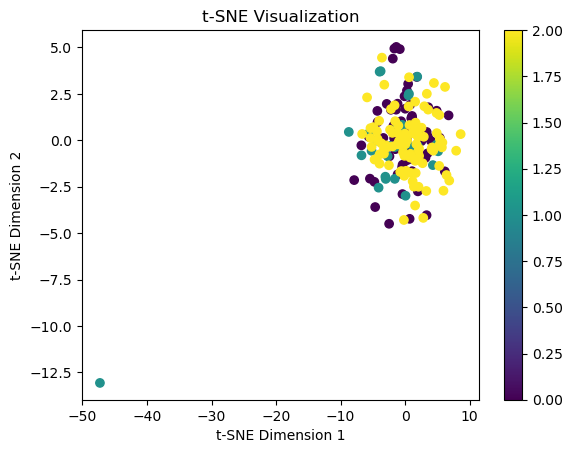

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=10, method='exact', random_state=42)
data_tsne = tsne.fit_transform(X)

plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=y)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.colorbar()
plt.show()